**DSTA-5511 Week 3**  
Mini Kaggle Project: Histopathologic Cancer Detection  


---

Problem Statement:  
The goal of this project is to build a binary classification model to identify metastatic cancer in small histopahology images.  
  
Dataset Overview:  
The dataset is provided as part of the Kaggle competition located [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview). It consists of small image files that contain pathology images that are labeled with 1 (cancerous) or 0 (non-cancerous).  
  
This project will proceed as follows:  


*   Data import
*   Exporatory Data Analysis (EDA)
*   Convolutional Neural Network (CNN) Model Creation
*   Model Training
*   Results and Analysis
*   Conclusions  
  


---


**Note:** the instructions include a submission requirement of an image of the standings in the kaggle competition. The competition has been completed for some time now, so I will be submitting a notebook and link to a github repo for this project.  



In [9]:
# Import necessary packages:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import models



---

Install and set up kaggle API to enable data import

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



---


# Data Import


---



In [4]:
# Import dataset from kaggle
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -q histopathologic-cancer-detection.zip -d /content/dataset

100% 6.31G/6.31G [04:47<00:00, 24.7MB/s]
100% 6.31G/6.31G [04:47<00:00, 23.5MB/s]


In [5]:
# Set Data Directory
DATA_DIR = "/content/dataset/"
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))

In [6]:
# Display dataset info
print("Dataset Overview:")
print(train_labels.head())

Dataset Overview:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0




---

# EDA


---



<function matplotlib.pyplot.show(close=None, block=None)>

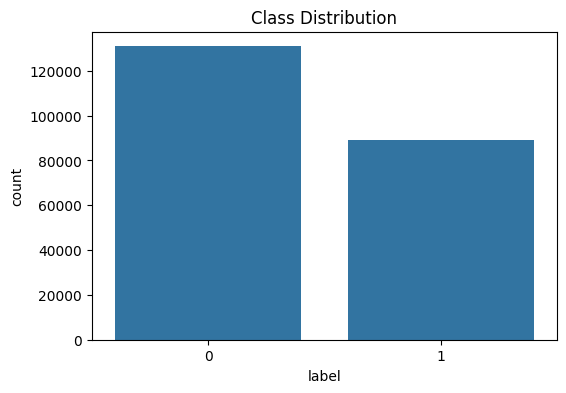

In [7]:
# Check class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_labels)
plt.title("Class Distribution")
plt.show

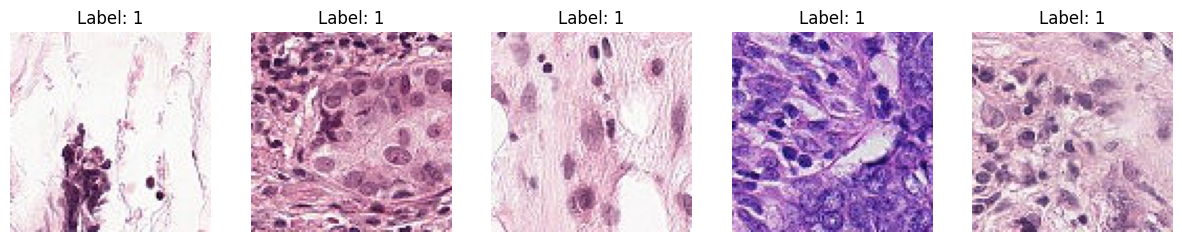

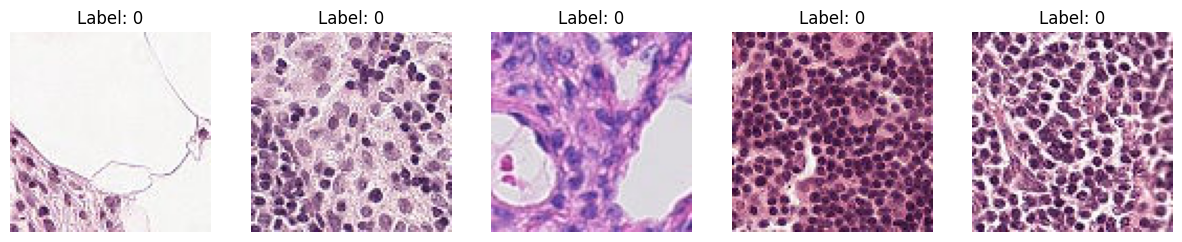

In [8]:
# Sample Image Visualization
def display_images(img_ids, label, n=5):
  fig, axes = plt.subplots(1, n, figsize=(15,5))
  for i, img_id in enumerate(img_ids[:n]):
    img_path = os.path.join(DATA_DIR, 'train', f'{img_id}.tif')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
  plt.show()

pos_samples = train_labels[train_labels['label'] == 1]['id'].values
neg_samples = train_labels[train_labels['label'] == 0]['id'].values

display_images(pos_samples, label=1)
display_images(neg_samples, label=0)

EDA Summary:  
The project contains over 200k images.  
The classes (cancerous vs. non-cancerouse) are not balanced and favor non-cancerous nearly 3:2.  
  
For the sake of training time, I will create a balanced set of 40,000 randomly sampled images (20k each), then further split the data to training and validation sets (80:20).

In [18]:
# Reduce and balance dataset to make training more manageable
sample_size_per_class = 20000

positive_samples = train_labels[train_labels['label'] == 1].sample(n=sample_size_per_class, random_state=42)
negative_samples = train_labels[train_labels['label'] == 0].sample(n=sample_size_per_class, random_state=42)

# combine and shuffle
train_labels_sampled = pd.concat([positive_samples, negative_samples]).sample(frac=1, random_state=42).reset_index(drop=True)
train_df, val_df = train_test_split(train_labels_sampled, test_size=0.2, random_state=42, stratify=train_labels_sampled['label'])

# Peak datasets
print("Train Data Overview:")
print(train_df.head())
print("Validation Data Overview:")
print(val_df.head())

Train Data Overview:
                                             id  label
17005  cb720b1340ae507dc746cb72e8e0af9386f6d27f      0
19930  f437e6897e2291e23cf585a71cb8fa33f75241f7      1
8641   52a13ca1edf34fc71134e4e8f7575aa6455bee0b      0
35026  888bc534d40fd881165b49c533ae776537df5b80      0
19704  89f44bf822e76bc0b974e0fe3fa6733ce1d743a9      1
Validation Data Overview:
                                             id  label
9247   fb29952b0ed6f51a5c0e5b43d4def25f1ce1ecb3      1
22015  e1c4892a202d16ca97cde51f3c1250f157db1967      0
12412  d2a5fa72de7dbe4c9c830d3896c90212ac522222      1
11669  55d1b423da9ff472eb23c3be7592501fa90a48ad      1
33890  c123025865e09ebe0a21c2b2b6cdf364362132f9      1




---

# CNN Model creation and training


---

Model architecture:  
  
I've seen a lot of examples for this project using Tensorflow, and therefore have chosen to use PyTorch to build my model as a learning opportunity.  
  
Preprocessing (Transform):  
Image preprocessing will consist of  


*   Convert OpenCV image to PIL image (needed for PyTorch transform)
*   Resize image to 32x32
*   Convert PIL to PyTorch tensor, which also scales the pixel values  
*   Normalize the image per RGB channel ((pixel - mean)/std)) - transforms pixel values to range [-1,1]  
  
The model will consist of a Convolutional Neural Network (CNN)  

Architecture of CNN:  
  
*   Input Layer (3-channel, RGB, 32x32 image)
*   Convolution Layer 1 (32 filters, activation - ReLU, followed by Max pooling layer)  
*   Convolution Layer 2 (64 filters, activation - ReLU, followed by Max pooling layer)
*   Flatten Layer (dynamically compute the size of the image after convolution layers, convert to 1d vector)
*   Fully connected layer (128 neurons, activation - ReLU)
*   Output layer (activation - Sigmoid)  
  
The model is trained using Binary Cross-Entropy Loss (BCELoss) with the Adam optimizer.





In [19]:
# Custom Dataset class
class CancerDataset(Dataset):
  def __init__(self, dataframe, img_dir, transform=None):
    self.dataframe = dataframe
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    img_id = self.dataframe.iloc[idx, 0]
    label = self.dataframe.iloc[idx, 1]
    img_path = os.path.join(self.img_dir, f'{img_id}.tif')
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transform:
      image = self.transform(image)

    return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CancerDataset(train_df, os.path.join(DATA_DIR, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model Definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.flatten_size = None

        # Calculate the output size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)  # Simulate a batch of 1 image (3,32,32)
            dummy_output = self._get_flatten_size(dummy_input)

        # Define fully connected layers
        self.fc1 = nn.Linear(dummy_output, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def _get_flatten_size(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=5):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.float().view(-1,1).to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

train_model(model, train_loader, criterion, optimizer, epochs=5)

print("Model training complete.")


Epoch 1, Loss: 0.4500526216775179
Epoch 2, Loss: 0.37938916769623754
Epoch 3, Loss: 0.35929313476383684
Epoch 4, Loss: 0.3367833800390363
Epoch 5, Loss: 0.3166620024442673
Model training complete.




---

# Results and Analysis


---



Accuracy: 0.8520
Precision: 0.8175
Recall: 0.9062
F1 Score: 0.8596
AUC-ROC: 0.8520


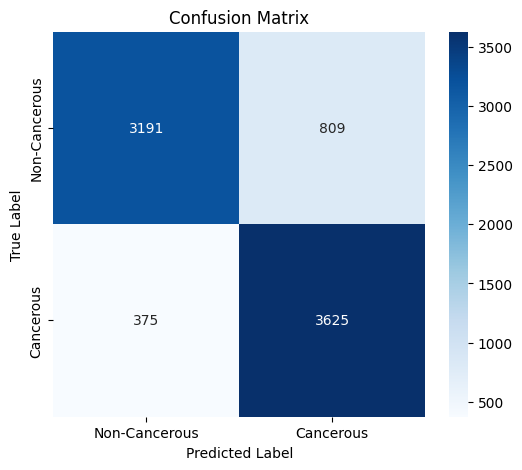

Model evaluation complete.


In [21]:
from google.colab import drive

val_dataset = CancerDataset(val_df, os.path.join(DATA_DIR, 'train'), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Evaluation Function
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            preds = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Cancerous", "Cancerous"], yticklabels=["Non-Cancerous", "Cancerous"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call Evaluation Function
evaluate_model(model, val_loader, device)

print("Model evaluation complete.")

Run model against test Kaggle dataset.

In [22]:
# Load Test Dataset
test_dir = os.path.join(DATA_DIR, 'test')
test_images = os.listdir(test_dir)

# Function to predict labels for test images
def predict_test_set(model, test_images, test_dir, device):
    model.eval()
    predictions = []
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    with torch.no_grad():
        for img_id in test_images:
            img_path = os.path.join(test_dir, img_id)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = transform(image).unsqueeze(0).to(device)

            output = model(image).squeeze().item()
            predicted_label = 1 if output > 0.5 else 0

            predictions.append((img_id.replace('.tif', ''), predicted_label))

    return predictions

# Generate predictions for the test set
test_predictions = predict_test_set(model, test_images, test_dir, device)

# Save predictions to a CSV file
submission_df = pd.DataFrame(test_predictions, columns=['id', 'label'])
submission_csv_path = "/content/submission.csv"
submission_df.to_csv(submission_csv_path, index=False)

print(f"Submission file saved at: {submission_csv_path}")

Submission file saved at: /content/submission.csv


In [23]:
# Download file for submission to kaggle.com
from google.colab import files
files.download("/content/submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---

# Conclusion


---

The project outlined above has been successfully completed.  
As part of this notebook I:


*   Imported Data successfully from Kaggle.com
*   Performed EDA
*   Used PyTorch to build and train a CNN Model
*   Evaluated the model for accuracy  
  
The model I build was accurate in identifying cancerous images 85% of the time. I think this is a good start. If I were to build on this project, I would expand the number of images that were used to train the model, as well as play around with the hyperparameters (loss, optimizer, learning rate, number of epochs, etc..) to see if I could improve the model.

